In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.39


In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

myworkspace	southeastasia	shrg	southeastasia


In [3]:
experiment_name = 'sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Resizing', 'allocationStateTransitionTime': '2019-05-21T08:37:58.304000+00:00', 'errors': None, 'creationTime': '2019-05-21T08:37:57.392704+00:00', 'modifiedTime': '2019-05-21T08:38:43.577244+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


In [5]:
import urllib.request
import os

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok = True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'train-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'train-labels.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'test-labels.gz'))

('C:\\Users\\Administrator\\Documents\\GitHub\\First-Step\\Test\\data\\test-labels.gz',
 <http.client.HTTPMessage at 0x19fe89ed4a8>)

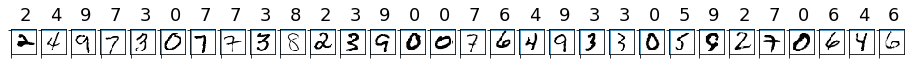

In [7]:
# make sure utils.py is in the same directory as this code
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [8]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir=data_folder, target_path='mnist', overwrite=True, show_progress=True)

AzureBlob myworkspstorage66603882c azureml-blobstore-750332db-0d0f-4fd6-9d39-b0214037ef7c
Uploading C:\Users\Administrator\Documents\GitHub\First-Step\Test\data\test-images.gz
Uploading C:\Users\Administrator\Documents\GitHub\First-Step\Test\data\test-labels.gz
Uploading C:\Users\Administrator\Documents\GitHub\First-Step\Test\data\train-images.gz
Uploading C:\Users\Administrator\Documents\GitHub\First-Step\Test\data\train-labels.gz
Uploaded C:\Users\Administrator\Documents\GitHub\First-Step\Test\data\test-labels.gz, 1 files out of an estimated total of 4
Uploaded C:\Users\Administrator\Documents\GitHub\First-Step\Test\data\train-labels.gz, 2 files out of an estimated total of 4
Uploaded C:\Users\Administrator\Documents\GitHub\First-Step\Test\data\test-images.gz, 3 files out of an estimated total of 4
Uploaded C:\Users\Administrator\Documents\GitHub\First-Step\Test\data\train-images.gz, 4 files out of an estimated total of 4


$AZUREML_DATAREFERENCE_d4ac3137d0a6416794ef9126cc336998

In [9]:
import os
script_folder  = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

In [10]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing C:\Users\Administrator\Documents\GitHub\First-Step\Test\sklearn-mnist/train.py


In [11]:
import shutil
shutil.copy('utils.py', script_folder)

'C:\\Users\\Administrator\\Documents\\GitHub\\First-Step\\Test\\sklearn-mnist\\utils.py'

In [12]:
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.path('mnist').as_mount(),
    '--regularization': 0.8
}

est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn'])

In [13]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
sklearn-mnist,sklearn-mnist_1558429464_c5ad1ea4,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [15]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [16]:
run.wait_for_completion(show_output=False) # specify True for a verbose log

{'runId': 'sklearn-mnist_1558429464_c5ad1ea4',
 'target': 'cpucluster',
 'status': 'Finalizing',
 'startTimeUtc': '2019-05-21T09:07:49.963637Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': 'e50ab662-a005-4a9e-a64b-e9403e87d836',
  'azureml.git.repository_uri': None,
  'azureml.git.branch': None,
  'azureml.git.commit': None,
  'azureml.git.dirty': 'False',
  'azureml.git.build_id': None,
  'azureml.git.build_uri': None,
  'mlflow.source.git.branch': None,
  'mlflow.source.git.commit': None,
  'mlflow.source.git.repoURL': None},
 'runDefinition': {'script': 'train.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_aca666a6be6640abbd4a86b0f67663af',
   '--regularization',
   '0.8'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpucluster',
  'dataReferences': {'aca666a6be6640abbd4a86b0f67663af': {'dataStoreName': 'workspaceblobstore',
    'mode': 'Mount',
    'pathOnDataStore': 'mnist',
   

In [17]:
print(run.get_metrics())

{'regularization rate': 0.8, 'accuracy': 0.9204}


In [18]:
print(run.get_file_names())

['azureml-logs/55_batchai_execution.txt', 'azureml-logs/60_control_log.txt', 'azureml-logs/80_driver_log.txt', 'azureml-logs/azureml.log', 'outputs/sklearn_mnist_model.pkl']


In [19]:
# register model 
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep = '\t')

sklearn_mnist	sklearn_mnist:1	1
